# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/home/macrodove/anaconda3/envs/sd35/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

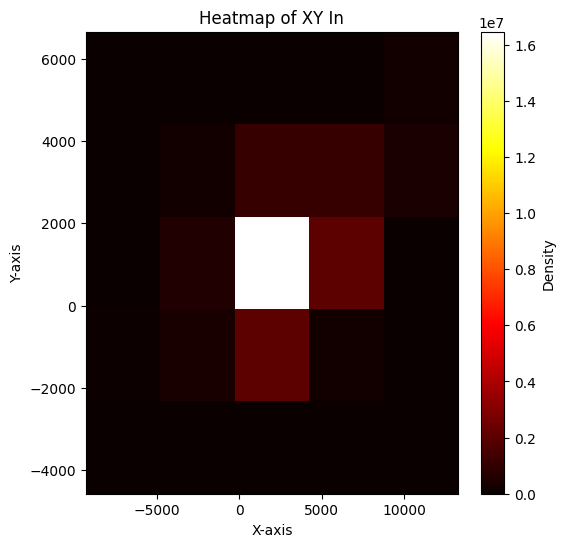

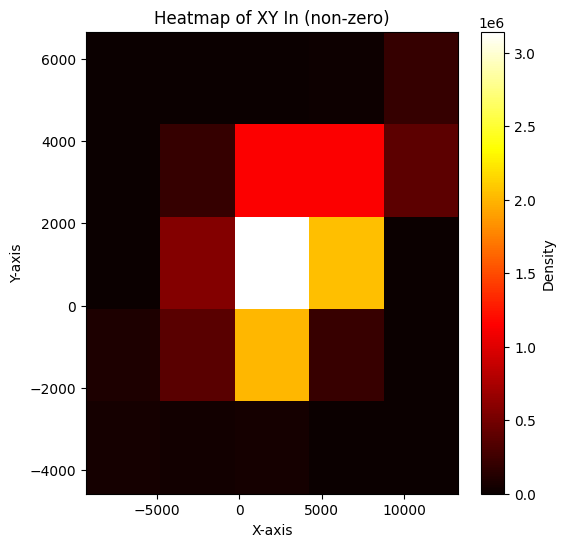

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

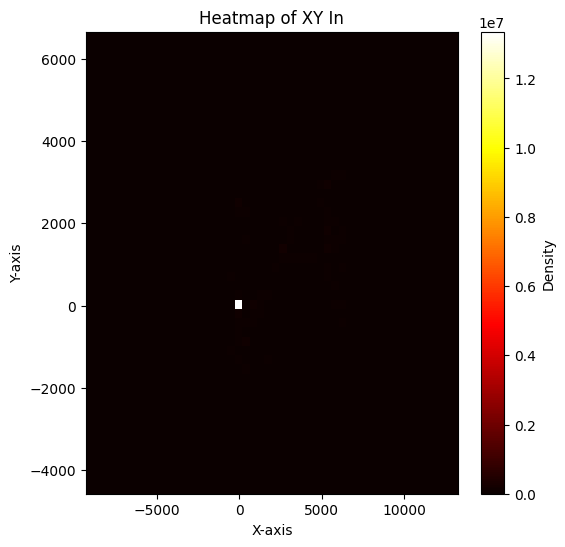

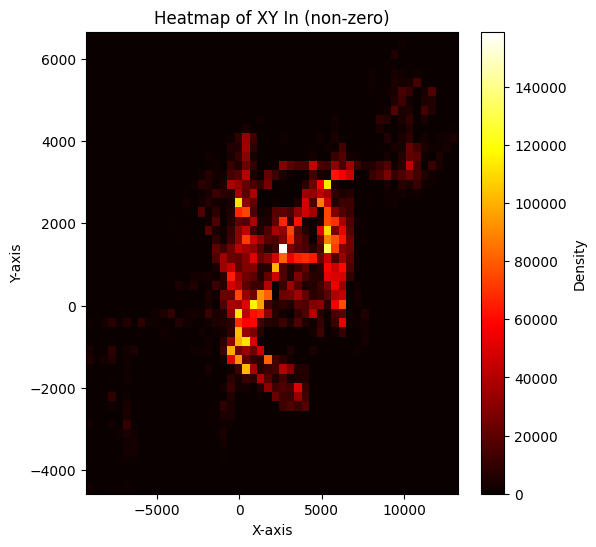

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

In [ ]:
label_map = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus',
             'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
active_type_ids = [0, 1, 2, 3, 4, 8]  # vehicle, pedestrian, motorcyclist, cyclist, bus, riderless_bicycle

def plot_avg_speed_of_active_agents(data):
    """
    Plot average speed for only active/moving agent types as a bar chart.
    """
    label_map = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus',
                 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
    
    active_type_ids = [0, 1, 2, 3, 4, 8]  # 动态 agent 类型的索引

    # object_type shape: (N_scenes, N_agents)
    object_types = data[..., 5][:, :, 0].astype(int).reshape(-1)

    # 平均速度计算
    vx = data[..., 2]
    vy = data[..., 3]
    speed = np.sqrt(vx**2 + vy**2)
    mask = speed > 0
    sum_speed = np.sum(speed * mask, axis=-1)
    count_speed = np.sum(mask, axis=-1)
    avg_speed = np.divide(sum_speed, count_speed, out=np.zeros_like(sum_speed), where=count_speed != 0).reshape(-1)

    # 初始化统计结果
    avg_speeds = []
    active_labels = []

    for i in active_type_ids:
        agent_mask = (object_types == i)
        if np.sum(agent_mask) > 0:
            mean_speed = np.mean(avg_speed[agent_mask])
            avg_speeds.append(mean_speed)
            active_labels.append(label_map[i])

    # 绘图
    plt.figure(figsize=(8, 5))
    plt.bar(active_labels, avg_speeds, color='teal', edgecolor='black')
    plt.xlabel('Agent Type')
    plt.ylabel('Average Speed (m/s)')
    plt.title('Average Speed of Active Agent Types')
    plt.tight_layout()
    plt.savefig("avg_speed_bar.png", dpi=100, bbox_inches='tight')
    plt.show()
plot_object_type_pie_with_legend(train_data, save_path='object_type_pie.png')


#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [16]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [17]:
# model = LinearRegressionModel().to(device)
model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

Epoch:   0%|          | 0/100 [00:03<?, ?epoch/s]

Epoch 000 | Learning rate 0.001000 | train normalized MSE  45.5068 | val normalized MSE   5.9341, | val MAE   9.4141 | val MSE 290.7693
Early stop!


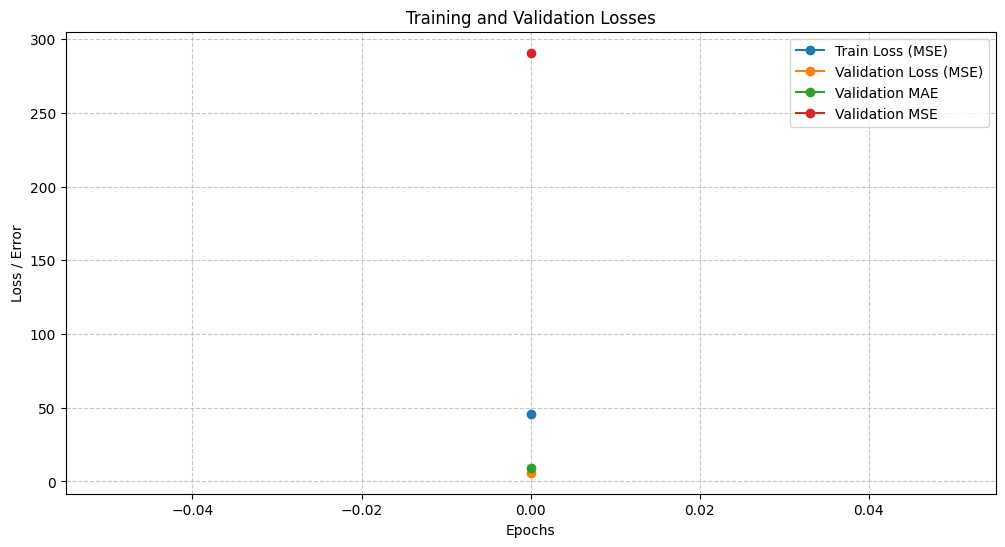

In [ ]:
train_losses = []
val_losses = []
val_mae_losses = []
val_mse_losses = []
epochs = []
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    epochs.append(epoch)
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        
        # Dynamically restore the batch shape
        B = batch.num_graphs  # True batch size (32)
        H, W, C = 50, 50, 6   # Expected shape of each sample
        
        # Reshape to (B, H, W, C)
        if batch.x.size(0) == B * H:  # 1600 = 32 * 50
            batch.x = batch.x.view(B, H, W, C)
        else:
            raise ValueError(f"Unexpected shape for x: {batch.x.shape}")

        pred = model(batch)
        y = batch.y.view(B, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)

            # Dynamically restore the batch shape
            B = batch.num_graphs  # True batch size (32)
            if batch.x.size(0) == B * H:  # 1600 = 32 * 50
                batch.x = batch.x.view(B, H, W, C)
            else:
                raise ValueError(f"Unexpected shape for val x: {batch.x.shape}")
            
            pred = model(batch)
            y = batch.y.view(B, 60, 2)
            val_loss += criterion(pred, y).item()

            # Unnormalized MAE and MSE
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)
    val_mse_losses.append(val_mse)
    
    scheduler.step(val_loss)
    
    tqdm.tqdm.write(
        f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} "
        f"| train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, "
        f"| val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}"
    )
    
    # ---- Early Stopping ----
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss (MSE)', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss (MSE)', marker='o')
plt.plot(epochs, val_mae, label='Validation MAE', marker='o')
plt.plot(epochs, val_mse, label='Validation MSE', marker='o')

plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss / Error")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [19]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

Shape of batch.x before model: torch.Size([50, 50, 6])
Reshaped to 4D: torch.Size([1, 50, 50, 6])
Shape of batch.x before model: torch.Size([50, 50, 6])
Reshaped to 4D: torch.Size([1, 50, 50, 6])
Shape of batch.x before model: torch.Size([50, 50, 6])
Reshaped to 4D: torch.Size([1, 50, 50, 6])
Shape of batch.x before model: torch.Size([50, 50, 6])
Reshaped to 4D: torch.Size([1, 50, 50, 6])


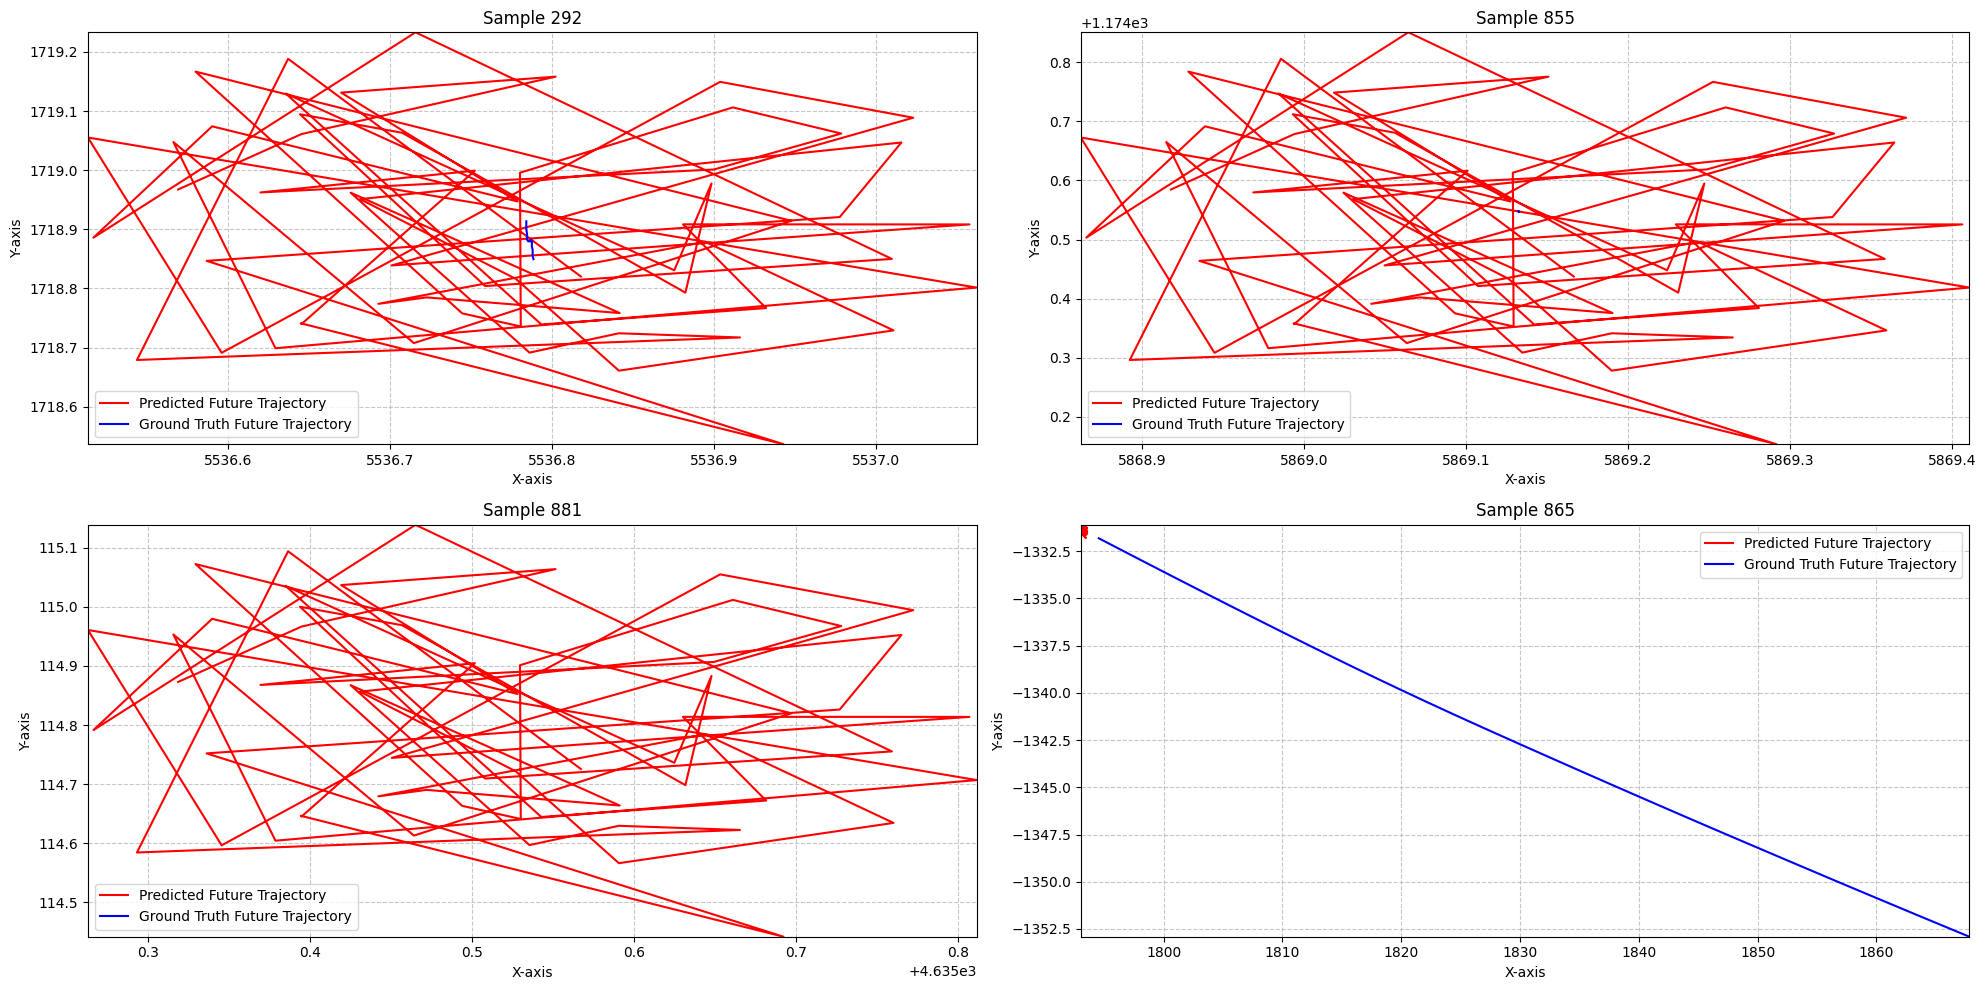

In [29]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    
    # Debug: Check the shape
    print("Shape of batch.x before model:", batch.x.shape)
    
    # Ensure 4D input for the model
    if batch.x.dim() == 3:
        H, W, C = 50, 50, 6  # Adjust these dimensions to match your model's expectation
        B = batch.x.size(0) // (H * W * C) if batch.x.size(0) % (H * W * C) == 0 else 1
        batch.x = batch.x.view(B, H, W, C)
        print("Reshaped to 4D:", batch.x.shape)
    
    # Model prediction
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    # Unnormalize predictions and ground truth
    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = gt * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    # Detach and convert to numpy
    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.tight_layout()
plt.show()



#### Output your predictions of the best model on the test set

In [ ]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
model = MLP().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

NameError: name 'LinearRegressionModel' is not defined

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B